In [3]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from functools import partial as partial_func
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing

### Generating taining and testing data

In [78]:
path = "/kaggle/input/daily-and-sports-activities/data"

In [79]:
print(os.listdir("/kaggle/input/daily-and-sports-activities/data/a03/p1"))

['s18.txt', 's31.txt', 's15.txt', 's03.txt', 's10.txt', 's20.txt', 's40.txt', 's09.txt', 's12.txt', 's50.txt', 's53.txt', 's25.txt', 's55.txt', 's33.txt', 's43.txt', 's39.txt', 's19.txt', 's23.txt', 's44.txt', 's49.txt', 's04.txt', 's08.txt', 's29.txt', 's47.txt', 's30.txt', 's48.txt', 's22.txt', 's32.txt', 's07.txt', 's21.txt', 's26.txt', 's45.txt', 's34.txt', 's60.txt', 's36.txt', 's17.txt', 's57.txt', 's54.txt', 's28.txt', 's05.txt', 's11.txt', 's37.txt', 's16.txt', 's38.txt', 's52.txt', 's56.txt', 's13.txt', 's06.txt', 's02.txt', 's24.txt', 's01.txt', 's59.txt', 's46.txt', 's14.txt', 's27.txt', 's58.txt', 's51.txt', 's35.txt', 's42.txt', 's41.txt']


In [80]:
def read_file(filename):
  """
    Return list of all 125 rows (125 * 45)
  """
  data = []
  with open(filename, 'r') as file:
    for line in file:
      row = [float(value) for value in line.strip().split(',')] # Converting to float
      data.append(row)
  return data

In [81]:
def approach_2_generator(list_of_rows):
    return [item for row in list_of_rows for item in row]

In [82]:
def approach_1_generator(list_of_rows):
    n = len(list_of_rows)
    mean_sample = [0 for _ in range(len(list_of_rows[0]))]
    for row in list_of_rows:
        for i in range(len(row)):
            mean_sample[i] += row[i]
    return [x / n for x in mean_sample]  

In [83]:
def generate_data(approach): 
    """
        This function generates and splits tainging and tesing data condering the approach desired. 
        approach = 1 -> Taking the mean of each column in each segment resulting in 45 features for each data point.
        approach = 2 -> Flattening all the features together in 45 x 125 = 5625 features for each data point.
    """
    training_data, training_labels, testing_data, testing_labels = [], [], [], []

    for activity in sorted(os.listdir(path)):
        label = int(activity[1:]) - 1   # To make it zero-based
        subjects_path = os.path.join(path, activity)
        # subject_path = path + '/' + activity
        for subject in sorted(os.listdir(subjects_path)):
            segments_path = os.path.join(subjects_path, subject)
            
            for segment in sorted(os.listdir(segments_path)):
                file_name =  os.path.join(segments_path, segment)
                data_sample = []
                
                if approach == 1:
                    data_sample = approach_1_generator(read_file(file_name))
                elif approach == 2:
                    data_sample = approach_2_generator(read_file(file_name))
    
                if int(segment[1:3]) <= 48: # Belongs to training data
                    training_data.append(data_sample)
                    training_labels.append(label)
                else:
                    testing_data.append(data_sample)
                    testing_labels.append(label)
    return  training_data , training_labels , testing_data , testing_labels
                
            

### Data generated by taking the mean of each column in each segment

In [84]:
training_data_1 , training_labels_1 , testing_data_1 , testing_labels_1 = generate_data(1)

### Data generated by flattening all the features together

In [86]:
training_data_2 , training_labels_2 , testing_data_2 , testing_labels_2 = generate_data(2)

### Testing the data

In [87]:
print(f"Training data in approach-1 is considered to be (7296 * 45) but it's ({len(training_data_1)} * {len(training_data_1[0])})")

Training data in approach-1 is considered to be (7296 * 45) but it's (7296 * 45)


In [88]:
print(f"Training data in approach-2 is considered to be (7296 * 5625) but it's ({len(training_data_2)} * {len(training_data_2[0])})")

Training data in approach-2 is considered to be (7296 * 5625) but it's (7296 * 5625)


### Normalizing featrues

In [89]:
scaler = MinMaxScaler()
# Normalizing approach 1
# TODO: remove
normalized_training_data_1 = training_data_1
normalized_testing_data_1 = testing_data_1

# Normalizing approach 2
scaler.fit(training_data_2)
normalized_training_data_2 = scaler.transform(training_data_2)
normalized_testing_data_2 = scaler.transform(testing_data_2)

### Applying dimensionality reduction using PCA

In [90]:
# pca = PCA(n_components=0.95)
pca = PCA(n_components=0.95)
pca.fit(normalized_training_data_2)
reduced_training_data_2 = pca.transform(normalized_training_data_2)
reduced_testing_data_2 = pca.transform(normalized_testing_data_2)

### Showing the effect of PCA

In [91]:
print(f"The dimensions of reduced flattened training data : {len(reduced_training_data_2)} * {len(reduced_training_data_2[0])}")
print(f"The dimensions of reduced flattened testing data : {len(reduced_testing_data_2)} * {len(reduced_testing_data_2[0])}")

The dimensions of reduced flattened training data : 7296 * 299
The dimensions of reduced flattened testing data : 1824 * 299


# Clustering evaluation

### External evaluation

In [250]:
def contingency_table(cluster_ids, labels):
    """
        Computes contingency_table given cluster ids (zero-based), labels (zero-based).
        returns contingency_table of size: |unique cluster_ids| * |unique labels|
    """    
    assert len(cluster_ids) == len(labels)
    n = int(max(cluster_ids) + 1)
    m = int(max(labels) + 1)
    contingency_table = np.zeros((n, m))
    for cluster, label in zip(cluster_ids, labels):
        contingency_table[cluster][label] += 1
    return contingency_table    

In [251]:
def match_cluster_label(contingency_table):
    """The index of the list is the cluster id, whereas list element is the corresponding label"""
    return np.argmax(contingency_table, axis = 1) # 0-based index labels if you want to match the real label add plus

In [252]:
def true_positive(contingency_table):
    tp = 0
    for row in contingency_table:
        for elem in row:
            tp += (elem * (elem - 1) / 2)
    return tp

In [253]:
def false_positive(contingency_table):
    fp = 0
    for row in contingency_table:
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                fp += (row[i] * row [j])
    return fp            

In [254]:
def confusion_matrix(contingency_table):
    """
        Calculates confusion matrix from contingency table
        return: True positive, True negative, False positive, False negative
    """
    tp, tn, fp, fn = 0 ,0 ,0 ,0
    # True positive
    tp  = true_positive(contingency_table)
    
    # False positive 
    fp = false_positive(contingency_table)
                
    # False negative
    fn = false_positive(contingency_table.T)
    
     
    # True negative
    tn = np.sum(contingency_table) - (tp + fp + fn)
    
    return tp, tn, fp, fn
            

In [255]:
def precision(contingency_table, number_of_samples):
    return sum(np.max(contingency_table, axis=1)) / number_of_samples

In [256]:
def precision_confusion(tp, tn, fp, fn):
    return tp / (tp + fp)

In [257]:
def recall(tp, tn, fp, fn):
    return tp / (tp + fn)

In [258]:
def f_measure(contingency_table):
    purity, recall, f_score = 0, 0, 0
    col_sum_list = np.sum(contingency_table, axis=0)
    number_of_samples = np.sum(contingency_table)
    for row in contingency_table:
        max_element = np.max(row)
        max_ind = np.argmax(row)
        
        number_of_elements_in_cluster = np.sum(row)
        # Only calculate the purity and recall for a cluster if it's not empty
        if number_of_elements_in_cluster != 0:
            purity = (max_element / number_of_elements_in_cluster)
            recall = (max_element / col_sum_list[max_ind])
        if purity != 0:
            f_score += 2 * ((purity * recall) / (purity + recall))
    return f_score / len(contingency_table)
        

In [259]:
def conditional_entropy(contingency_table, number_of_samples):
    entropy = 0
    for row in contingency_table:
        num_elements_of_cluster = np.sum(row)
        if num_elements_of_cluster != 0:
            cluster_entropy = 0
            for col in row:
                p = col / num_elements_of_cluster
                if p != 0:
                    cluster_entropy -=  (p * np.log2(p))
            entropy += ((num_elements_of_cluster / number_of_samples) * cluster_entropy)
    return entropy    

In [260]:
def perform_external_measures(contingency_table, number_of_samples):
    tp, tn, fp, fn = confusion_matrix(contingency_table)
    print(f"Precision is {precision(contingency_table, number_of_samples)}")
    print(f"Recall is {recall(tp, tn, fp, fn)}")
    print(f"F-score is {f_measure(contingency_table)}")
    print(f"Conditional entropy is {conditional_entropy(contingency_table, number_of_samples)}")
    return [precision(contingency_table, number_of_samples), recall(tp, tn, fp, fn), f_measure(contingency_table), conditional_entropy(contingency_table, number_of_samples)]

# K-means

## Work flow

In [261]:
def kmeans(data, k, max_iter=1000, tol=1e-6):
    # Convert data to numpy array
    data = np.array(data)
    
    # Initialize centroids randomly
    centroids = [data[i] for i in np.random.choice(range(len(data)), k, replace=False)]
    
    # Initialize cluster assignments as integers
#     clusters = np.zeros(len(data), dtype=int)
    clusters = np.array([int(0) for i in range(len(data))])
    
    for _ in range(max_iter):
        # Assign each data point to the nearest centroid
        for i, point in enumerate(data):
            distances =  np.linalg.norm(np.array(point) - np.array(centroids), axis=1)
            clusters[i] = np.argmin(distances)
        
        # Update centroids
        new_centroids = np.array([np.mean(data[np.where(clusters == i)], axis=0) for i in range(k)])
        
        # Check convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        
        centroids = new_centroids
    
    return clusters, centroids

In [262]:
def predict(data, centroids):
    clusters = np.zeros(len(data), dtype=int)
    for i, point in enumerate(data):
        distances = np.linalg.norm(point - centroids, axis=1)
        clusters[i] = np.argmin(distances)
    return clusters

In [263]:
def get_accuracy(clusters, labels, cluster_assignments):
    correct = 0
    for i in range(len(clusters)):
        if cluster_assignments[int(clusters[i])] == labels[i]:
            correct += 1
    return correct / len(labels)

In [264]:
def run_kmeans(training_data, testing_data, training_labels, testing_labels, k):
    training_predictions, centroids = kmeans(training_data, k)
    testing_predictions = predict(testing_data, centroids)
    
    contegncy_table_training = contingency_table(training_predictions, training_labels)
    contegncy_table_testing = contingency_table(testing_predictions, testing_labels)

    cluster_assignments = match_cluster_label(contegncy_table_training)
    return get_accuracy(training_predictions, training_labels, cluster_assignments), get_accuracy(testing_predictions, testing_labels, cluster_assignments), contegncy_table_training, contegncy_table_testing

In [265]:
k_list = [8, 13, 19, 28, 38]

## Approach 1

In [266]:
evaluation_k_mean_training_app_1 = []
evaluation_k_mean_testing_app_1 = []

In [279]:
for k in k_list:
    print(f"\033[92m K : {k} \033[0m")
    training_accuracy1, testing_accuracy1, contengency_table_training_1, contengency_table_testing_1 = run_kmeans(normalized_training_data_1, normalized_testing_data_1, training_labels_1, testing_labels_1, k)
    
    # Evaluate clustering (training)
    print("\033[91m \nTraining evaluation\n \033[0m")
    evaluation_k_means_app_training_1 = perform_external_measures(contengency_table_training_1, len(normalized_training_data_1))
    evaluation_k_mean_training_app_1.append(evaluation_k_means_app_training_1)
    
    # Evaluate clustering (testing)
    print("\033[91m \nTesting evaluation\n \033[0m")
    evaluation_k_means_app_testing_1 = perform_external_measures(contengency_table_testing_1, len(normalized_testing_data_1))
    evaluation_k_mean_testing_app_1.append(evaluation_k_means_app_testing_1)
    
    print(f"\033[94m \ntraining accuracy: {training_accuracy1}\t testing accuracy: {testing_accuracy1} \033[0m")
    print('-' * 80)

 K : 8 
 
Training evaluation
 
Precision is 0.29509320175438597
Recall is 0.5464498591452521
F-score is 0.44447680057792
Conditional entropy is 2.538216266869179
 
Testing evaluation
 
Precision is 0.2905701754385965
Recall is 0.5500692520775623
F-score is 0.44445407491983563
Conditional entropy is 2.504626589055863
 
training accuracy: 0.29509320175438597	 testing accuracy: 0.2905701754385965 
--------------------------------------------------------------------------------
 K : 13 
 
Training evaluation
 
Precision is 0.4805372807017544
Recall is 0.5865333413494572
F-score is 0.5901100732326381
Conditional entropy is 1.972892807251191
 
Testing evaluation
 
Precision is 0.48464912280701755
Recall is 0.5850184672206833
F-score is 0.6090553104568841
Conditional entropy is 1.973360379997946
 
training accuracy: 0.4805372807017544	 testing accuracy: 0.48464912280701755 
--------------------------------------------------------------------------------
 K : 19 
 
Training evaluation
 
Preci

## Approach 2

In [280]:
evaluation_k_mean_training_app_2 = []
evaluation_k_mean_testing_app_2 = []

In [281]:
for k in k_list:
    training_accuracy2, testing_accuracy2,  contengency_table_training_2, contengency_table_testing_2 = run_kmeans(reduced_training_data_2, reduced_testing_data_2, training_labels_2, testing_labels_2, k)
    print(f"\033[92m K : {k} \033[0m")
    # Evaluate clustering (training)
    print("\033[91m \nTraining evaluation\n \033[0m")
    evaluation_k_means_app_training_2 = perform_external_measures(contengency_table_training_2, len(reduced_training_data_2))
    evaluation_k_mean_training_app_2.append(evaluation_k_means_app_training_2)

    # Evaluate clustering (testing)
    print("\033[91m \nTesting evaluation\n \033[0m")
    evaluation_k_means_app_testing_2 = perform_external_measures(contengency_table_testing_2, len(reduced_testing_data_2))
    evaluation_k_mean_testing_app_2.append(evaluation_k_means_app_testing_2)
    
    print(f"\033[94m \ntraining accuracy: {training_accuracy2}\t testing accuracy: {testing_accuracy2} \033[0m")
    print('-' * 80)

 K : 8 
 
Training evaluation
 
Precision is 0.36554276315789475
Recall is 0.6062415544409326
F-score is 0.5472439909004391
Conditional entropy is 2.307936620452125
 
Testing evaluation
 
Precision is 0.36896929824561403
Recall is 0.6115766389658357
F-score is 0.5548398373756382
Conditional entropy is 2.3031069766361574
 
training accuracy: 0.36554276315789475	 testing accuracy: 0.36896929824561403 
--------------------------------------------------------------------------------
 K : 13 
 
Training evaluation
 
Precision is 0.4634046052631579
Recall is 0.571289107232834
F-score is 0.5532666494238739
Conditional entropy is 1.922288902958042
 
Testing evaluation
 
Precision is 0.46765350877192985
Recall is 0.5667128347183749
F-score is 0.564126284937241
Conditional entropy is 1.917889788450215
 
training accuracy: 0.4634046052631579	 testing accuracy: 0.46765350877192985 
--------------------------------------------------------------------------------
 K : 19 
 
Training evaluation
 
Pre

<h2 style="color:purple">Spectral clustering</h2>

## Work flow

In [282]:
def RBF_kernel(v1, v2, gamma):
    d = np.linalg.norm(v1 - v2)
    return np.exp(-gamma * d**2)

In [283]:
def knn_similarity_k(k):
    def knn_similarity(D):
        model = NearestNeighbors(n_neighbors=k, metric='euclidean')
        model.fit(D)

        # Compute k-NN indices
        distances, indices = model.kneighbors(D)
        
        n = len(D)
        # Create an empty adjacency matrix
        A = np.zeros((n, n))

        # Fill in the similarity matrix
        for i in range(n):
            for j in indices[i]:
                A[i, j] = 1
                A[j, i] = 1  # For symmetry: j is also a neighbor of i

        return A
    return knn_similarity

In [284]:
def spectral_clustering(D, k, sim_func):
  epsilon = 1e-10
  # Compute similarity matrix
  A = sim_func(D)

  # Compute degree matrix
  degrees = np.sum(A, axis=1)
  degree_mat = np.diag(degrees)

  # Compute Laplacian asymetric matrix
  la = np.eye(len(D)) - np.linalg.inv(degree_mat) @ A

  eigenvalues, eigenvectors = np.linalg.eig(la)

  # Sort eigenvalues and eigenvectors in ascending order
  sorted_indices = np.argsort(eigenvalues)
  sorted_eigenvalues = eigenvalues[sorted_indices]
  sorted_eigenvectors = eigenvectors[:, sorted_indices]

  # Choose the smallest K eigenvectors
  smallest_eigenvectors = sorted_eigenvectors[:k, :]
  
  # Normalize each row
  reduced_data  = (np.real(smallest_eigenvectors).T)
  
  for i in range(len(reduced_data)):
        reduced_data[i] = reduced_data[i] / (np.linalg.norm(reduced_data[i]) + epsilon)
  return reduced_data
      

<h2 style="color:blue">Applying spectral clustering to app. 1</h2>

In [285]:
# State init
gamma_list = [0.0001] # Don't ever use gamma = 1
k = 19
evaluation_spectral_app_1 = []
evaluation_spectral_app_2 = []
# Function init
knn_sim = knn_similarity_k(10)
sim_func_list = [knn_sim, cosine_similarity, np.corrcoef]

In [287]:
number_of_samples_spectral_app_1 = len(normalized_training_data_1)
for sim_func in sim_func_list:
    print(f"Evaluation of spectral clustering using similarity measure : \033[94m{sim_func.__name__.upper()}\033[0m")
    reduced_training_data_spectral_cosine_app_1 = spectral_clustering(normalized_training_data_1, k, sim_func) # Replace test

    # Cluster traing data using k-means and return cluster id for each training sample
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_training_data_spectral_cosine_app_1)
    cluster_ids_spectral_app_1 = kmeans.labels_
    
    # Create contingency table matrix for matching training data clusters
    contingency_table_spectral_app_1 = contingency_table(cluster_ids_spectral_app_1, training_labels_1)
    
    # Evaluate clustering
    evaluation_spectral_app_1.append(perform_external_measures(contingency_table_spectral_app_1, number_of_samples_spectral_app_1))
    print("-" * 80)
    

Evaluation of spectral clustering using similarity measure : KNN_SIMILARITY


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Precision is 0.05688048245614035
Recall is 0.9893686157299253
F-score is 0.013728379374446674
Conditional entropy is 4.227989754914487
--------------------------------------------------------------------------------
Evaluation of spectral clustering using similarity measure : COSINE_SIMILARITY


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Precision is 0.4233826754385965
Recall is 0.3372190062296734
F-score is 0.4373339052798815
Conditional entropy is 2.160124760886055
--------------------------------------------------------------------------------
Evaluation of spectral clustering using similarity measure : CORRCOEF


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Precision is 0.39035087719298245
Recall is 0.3119123894920068
F-score is 0.39551971878686243
Conditional entropy is 2.2882931895631167
--------------------------------------------------------------------------------


## Applying spectral clustering to app. 2

In [288]:
number_of_samples_spectral_app_2 = len(reduced_training_data_2)
for sim_func in sim_func_list:
    print(f"Evaluation of spectral clustering using similarity measure : \033[94m{sim_func.__name__.upper()}\033[0m")
    reduced_training_data_spectral_cosine_app_2 = spectral_clustering(reduced_training_data_2, k, sim_func) # Replace test

    # Cluster traing data using k-means and return cluster id for each training sample
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_training_data_spectral_cosine_app_2)
    cluster_ids_spectral_app_2 = kmeans.labels_
    
    # Create contingency table for matching training data clusters
    contingency_table_spectral_app_2 = contingency_table(cluster_ids_spectral_app_2, training_labels_2)
    
    # Evaluate clustering
    evaluation_spectral_app_2.append(perform_external_measures(contingency_table_spectral_app_2, number_of_samples_spectral_app_2))
    print("\n")
    

Evaluation of spectral clustering using similarity measure : KNN_SIMILARITY


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Precision is 0.3782894736842105
Recall is 0.3170591704456965
F-score is 0.3990549744528832
Conditional entropy is 2.4099442893838408


Evaluation of spectral clustering using similarity measure : COSINE_SIMILARITY


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Precision is 0.36101973684210525
Recall is 0.34510486807750446
F-score is 0.37460186562657344
Conditional entropy is 2.116355272332628


Evaluation of spectral clustering using similarity measure : CORRCOEF


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Precision is 0.41296600877192985
Recall is 0.3618005931931657
F-score is 0.42840550354072304
Conditional entropy is 1.9978442184442002




<h2 style="color:blue">Comparision</h2>

In [ ]:
measure_list = ["Precision", "Recall", "F-score", "Conditional entropy"]

## Approach 1

In [293]:
# K means evaluation
k_mean_training_eval_1 = np.mean(evaluation_k_mean_training_app_1, axis=0)
print(k_mean_training_eval_1)
# spectral evaluation
spectral_training_eval_1 =  np.mean(evaluation_spectral_app_1, axis=0)
print(spectral_training_eval_1)


[0.43925732 0.48841205 0.47353378 2.01440082]
[0.29020468 0.54616667 0.282194   2.8921359 ]


### Plot

In [294]:
x = np.arange(len(measure_list))  
width = 0.35 

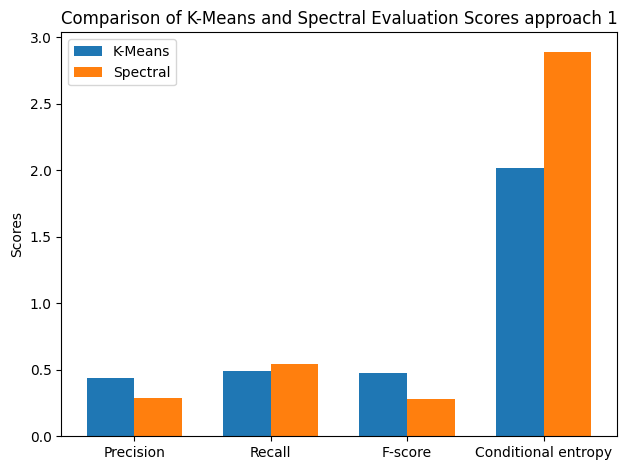

In [295]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, k_mean_training_eval_1, width, label='K-Means')
rects2 = ax.bar(x + width/2, spectral_training_eval_1, width, label='Spectral')

ax.set_ylabel('Scores')
ax.set_title('Comparison of K-Means and Spectral Evaluation Scores approach 1')
ax.set_xticks(x)
ax.set_xticklabels(measure_list)
ax.legend()

fig.tight_layout()

plt.show()

## Approach 2

In [297]:
# K means evaluation
k_mean_training_eval_2 = np.mean(evaluation_k_mean_training_app_2, axis=0)
print(k_mean_training_eval_2)
# spectral evaluation
spectral_training_eval_2 =  np.mean(evaluation_spectral_app_2, axis=0)
print(spectral_training_eval_2)

[0.54394189 0.51903128 0.5082322  1.62711892]
[0.38409174 0.34132154 0.40068745 2.17471459]


### Plot

In [298]:
x = np.arange(len(measure_list))  
width = 0.35 

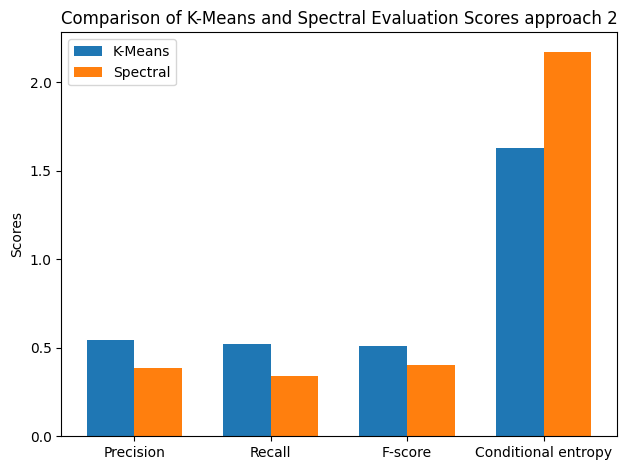

In [299]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, k_mean_training_eval_2, width, label='K-Means')
rects2 = ax.bar(x + width/2, spectral_training_eval_2, width, label='Spectral')

ax.set_ylabel('Scores')
ax.set_title('Comparison of K-Means and Spectral Evaluation Scores approach 2')
ax.set_xticks(x)
ax.set_xticklabels(measure_list)
ax.legend()

fig.tight_layout()

plt.show()

# DBSCAN Clustering

In [301]:
# Helper method to find the neighbors of a given data point
def find_neighbors(data, index, eps):
    # Calculate the Euclidean distance between the current data point and all other data points
    distances = np.linalg.norm(data - data[index], axis=1)

    # Find the indices of the neighbors within the specified epsilon radius
    neighbors = np.where(distances <= eps)[0]

    return neighbors

# Helper method to grow a new cluster or expand an existing one
def expand_cluster(data, labels, index, neighbors, cluster_id, eps, min_samples):
    # Assign the cluster label to the current data point
    labels[index] = cluster_id

    # Iterate over each neighbor of the current data point
    for neighbor in neighbors:
        # Skip if the neighbor is already assigned to a cluster
        if labels[neighbor] != 0:
            continue

        # Find the neighbors of the current neighbor
        neighbor_neighbors = find_neighbors(data, neighbor, eps)

        # If the number of neighbors is greater than or equal to min_samples, add them to the current cluster
        if len(neighbor_neighbors) >= min_samples:
            neighbors = np.concatenate((neighbors, neighbor_neighbors))

        # Assign the cluster label to the current neighbor
        labels[neighbor] = cluster_id

def dbscan(data, eps, min_samples):
    # Initialize the cluster labels
    labels = np.zeros(len(data), dtype=int)
    cluster_id = 0

    # Iterate over each data point
    for i in range(len(data)):
        # Skip if the data point is already assigned to a cluster
        if labels[i] != 0:
            continue

        # Find the neighbors of the current data point
        neighbors = find_neighbors(data, i, eps)

        # If the number of neighbors is less than min_samples, mark the data point as noise
        if len(neighbors) < min_samples:
            labels[i] = -1
        else:
            # Expand the cluster starting from the current data point
            cluster_id += 1
            expand_cluster(data, labels, i, neighbors, cluster_id, eps, min_samples)

    labels = [label if label != -1 else 0 for label in labels]

    return labels

# Applying DBSCAN app. 1

# Training

In [310]:
eps_values = np.arange(1, 4, 0.5).tolist()
num_samples_values = np.arange(3, 6, 1).tolist()

# Initialize lists to store the values
precision_values = []
recall_values = []
f_measure_values = []
entropy_values = []

for num in num_samples_values:
    print("For num =", num)
    for eps in eps_values:
        print("For eps =", eps)
        cluster_labels = dbscan(np.array(normalized_training_data_1), eps, num)
        
        # Create confusion matrix for matching training data clusters
        confusion_mat = contingency_table(cluster_labels, training_labels_1)

        # Evaluate clustering
        number_of_samples = len(normalized_training_data_1)
        measures = perform_external_measures(confusion_mat, number_of_samples)

        # Append the measures to the respective lists
        precision_values.append(measures[0])
        recall_values.append(measures[1])
        f_measure_values.append(measures[2])
        entropy_values.append(measures[3])
        print()

For num = 3
For eps = 1.0
Precision is 0.7741228070175439
Recall is 0.19376760684347946
F-score is 0.0336132466171751
Conditional entropy is 0.9743540341663073

For eps = 1.5
Precision is 0.8952850877192983
Recall is 0.13795391301360452
F-score is 0.0477726937821018
Conditional entropy is 0.4685865022582791

For eps = 2.0
Precision is 0.912828947368421
Recall is 0.1342643488617104
F-score is 0.06323471793012035
Conditional entropy is 0.3572272360413257

For eps = 2.5
Precision is 0.8736293859649122
Recall is 0.12578872932985205
F-score is 0.07425809154275535
Conditional entropy is 0.4486678260115638

For eps = 3.0
Precision is 0.8201754385964912
Recall is 0.11513587329943659
F-score is 0.07550901699110744
Conditional entropy is 0.5970654837818341

For eps = 3.5
Precision is 0.782483552631579
Recall is 0.11962203975997435
F-score is 0.077240034158346
Conditional entropy is 0.738338365102837

For num = 4
For eps = 1.0
Precision is 0.7420504385964912
Recall is 0.21778090788328525
F-score 

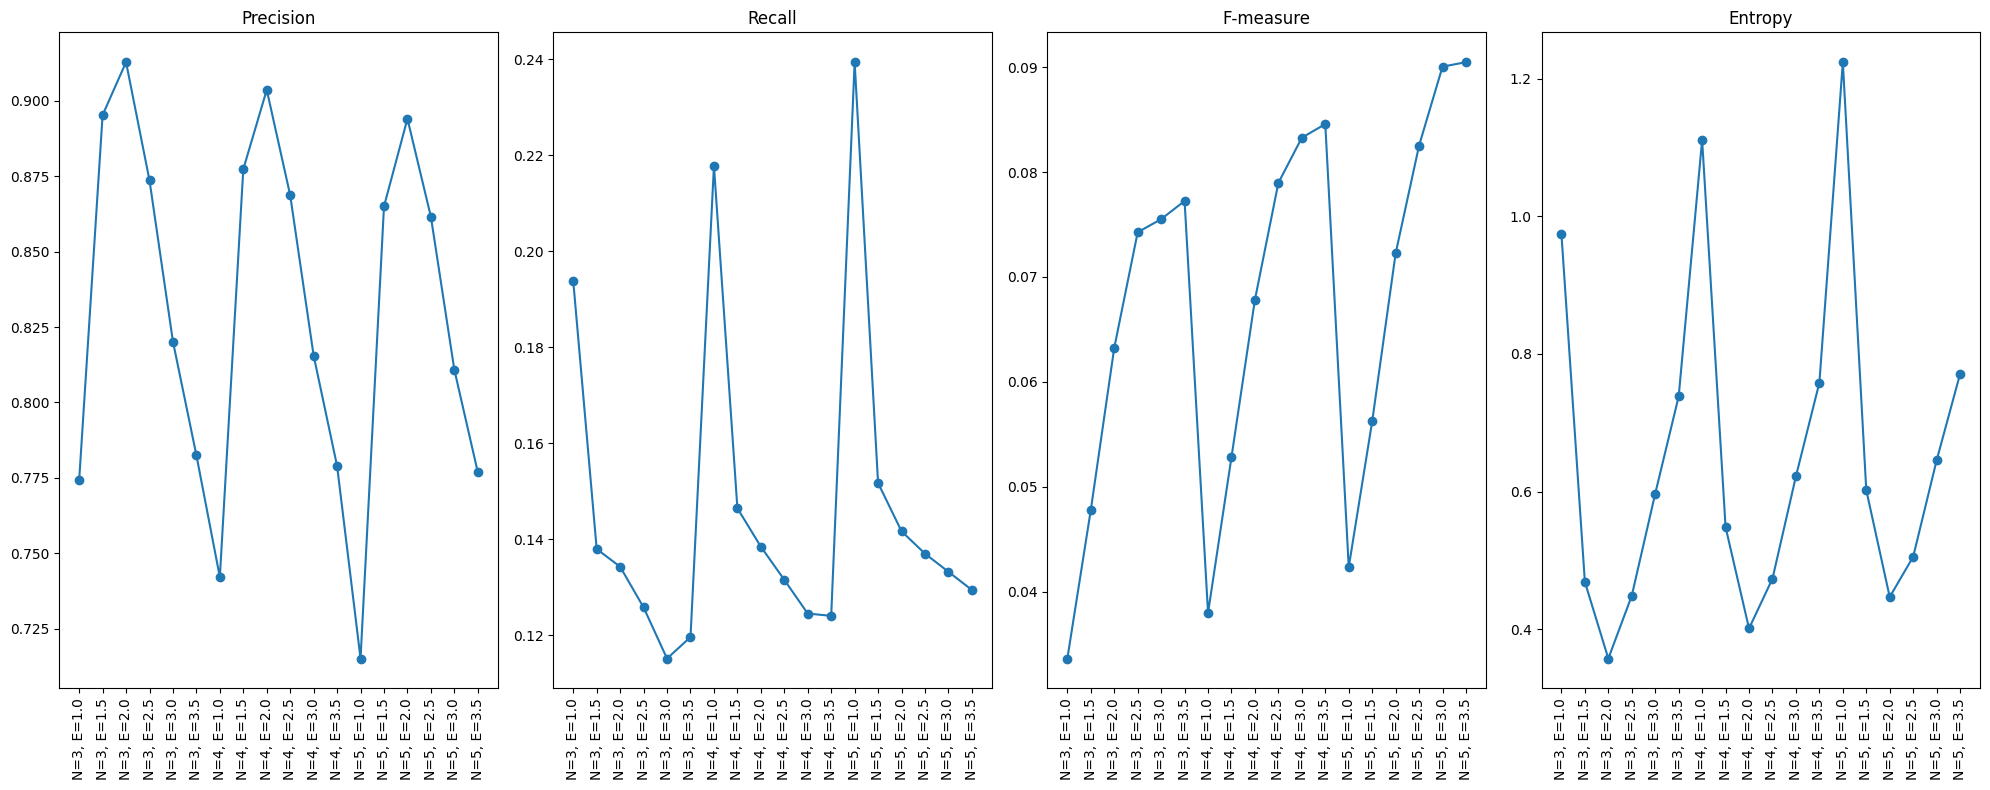

In [311]:
# Create x values for the plot
x_values = [f'N={num}, E={eps}' for num in num_samples_values for eps in eps_values]

# Create the plots
plt.figure(figsize=(20, 8))

plt.subplot(1, 4, 1)
plt.plot(x_values, precision_values, marker='o')
plt.title('Precision')
plt.xticks(rotation=90)

plt.subplot(1, 4, 2)
plt.plot(x_values, recall_values, marker='o')
plt.title('Recall')
plt.xticks(rotation=90)

plt.subplot(1, 4, 3)
plt.plot(x_values, f_measure_values, marker='o')
plt.title('F-measure')
plt.xticks(rotation=90)

plt.subplot(1, 4, 4)
plt.plot(x_values, entropy_values, marker='o')
plt.title('Entropy')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Testing

In [312]:
eps_values = np.arange(1, 4, 0.5).tolist()
num_samples_values = np.arange(3, 6, 1).tolist()

# Initialize lists to store the values
precision_values = []
recall_values = []
f_measure_values = []
entropy_values = []

for num in num_samples_values:
    print("For num =", num)
    for eps in eps_values:
        print("For eps =", eps)
        cluster_labels = dbscan(np.array(normalized_testing_data_1), eps, num)
        
        # Create confusion matrix for matching training data clusters
        confusion_mat = contingency_table(cluster_labels, testing_labels_1)

        # Evaluate clustering
        number_of_samples = len(normalized_testing_data_1)
        measures = perform_external_measures(confusion_mat, number_of_samples)

        # Append the measures to the respective lists
        precision_values.append(measures[0])
        recall_values.append(measures[1])
        f_measure_values.append(measures[2])
        entropy_values.append(measures[3])
        print()

For num = 3
For eps = 1.0
Precision is 0.762609649122807
Recall is 0.23119806094182827
F-score is 0.10451451103888988
Conditional entropy is 0.9865302388584883

For eps = 1.5
Precision is 0.8793859649122807
Recall is 0.17289935364727607
F-score is 0.12561276837460233
Conditional entropy is 0.49657426734613036

For eps = 2.0
Precision is 0.899671052631579
Recall is 0.16605493998153278
F-score is 0.15043939922791105
Conditional entropy is 0.3760265366086436

For eps = 2.5
Precision is 0.8722587719298246
Recall is 0.1608264081255771
F-score is 0.1623001807664169
Conditional entropy is 0.4331859114909499

For eps = 3.0
Precision is 0.8157894736842105
Recall is 0.14511772853185595
F-score is 0.16512123630374656
Conditional entropy is 0.5840951801931605

For eps = 3.5
Precision is 0.7648026315789473
Recall is 0.14544090489381348
F-score is 0.16829218634472895
Conditional entropy is 0.7938397548864838

For num = 4
For eps = 1.0
Precision is 0.7099780701754386
Recall is 0.27130655586334257
F-s

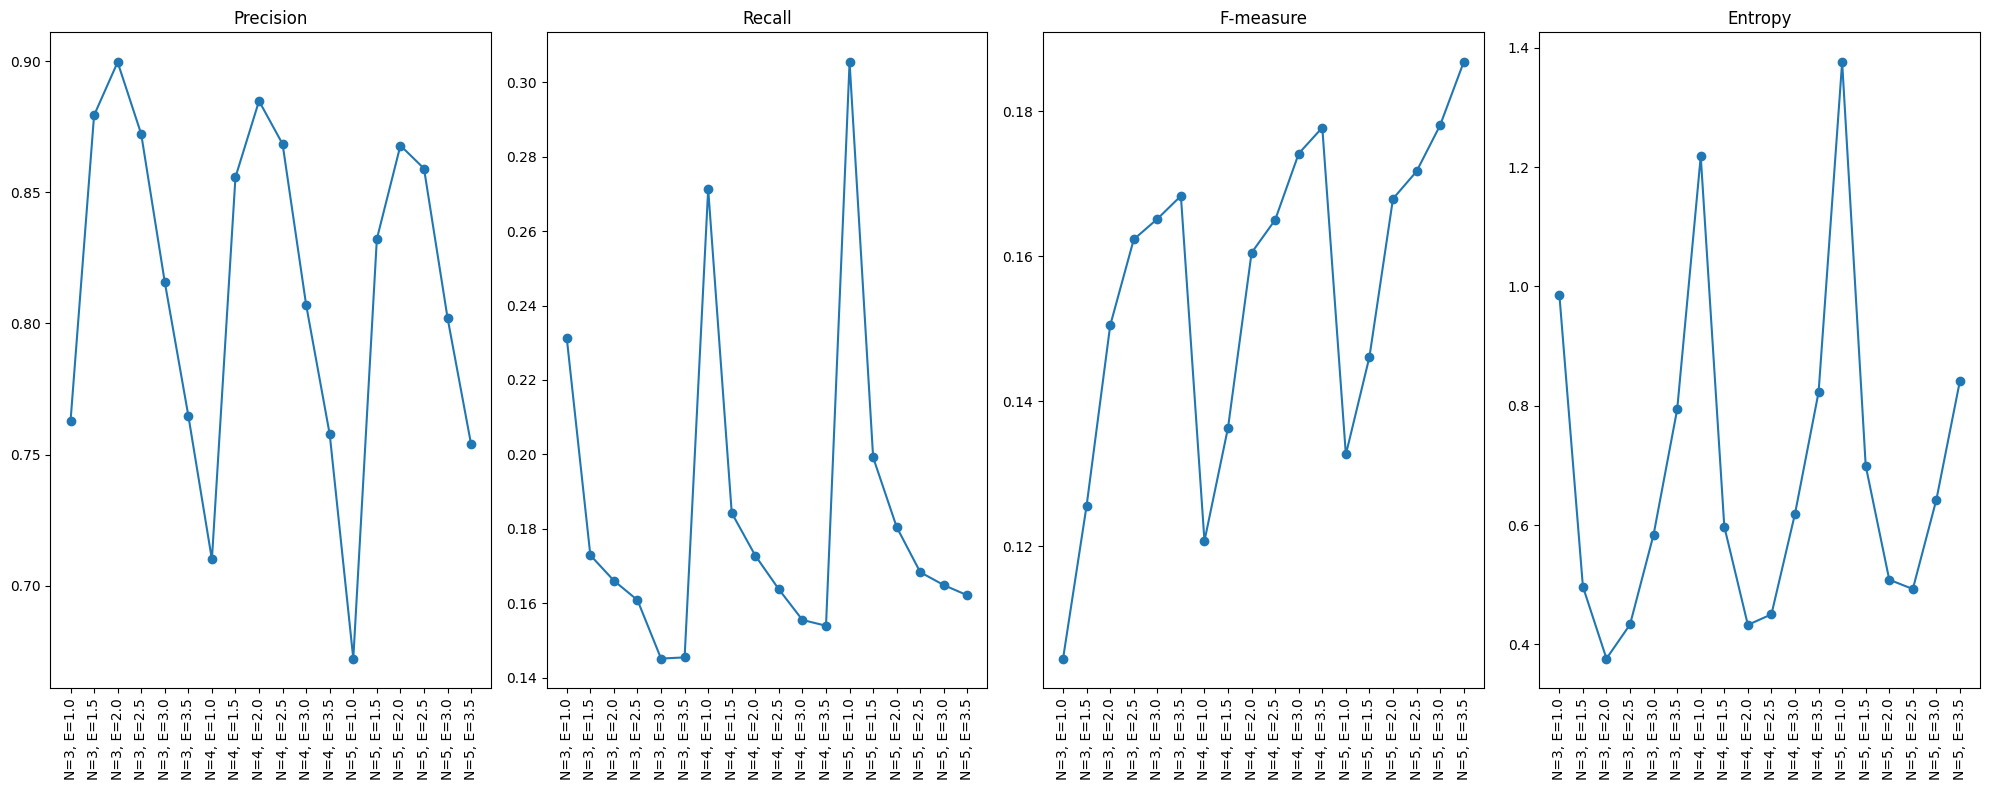

In [313]:
# Create x values for the plot
x_values = [f'N={num}, E={eps}' for num in num_samples_values for eps in eps_values]

# Create the plots
plt.figure(figsize=(20, 8))

plt.subplot(1, 4, 1)
plt.plot(x_values, precision_values, marker='o')
plt.title('Precision')
plt.xticks(rotation=90)

plt.subplot(1, 4, 2)
plt.plot(x_values, recall_values, marker='o')
plt.title('Recall')
plt.xticks(rotation=90)

plt.subplot(1, 4, 3)
plt.plot(x_values, f_measure_values, marker='o')
plt.title('F-measure')
plt.xticks(rotation=90)

plt.subplot(1, 4, 4)
plt.plot(x_values, entropy_values, marker='o')
plt.title('Entropy')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Applying DBSCAN app. 2

# Training

In [314]:
eps_values = [4.5]
num_samples_values = [3]

# Initialize lists to store the values
precision_values = []
recall_values = []
f_measure_values = []
entropy_values = []

for num in num_samples_values:
    for eps in eps_values:
        cluster_labels = dbscan(np.array(reduced_training_data_2), eps, num)
        
        # Create confusion matrix for matching training data clusters
        confusion_mat = contingency_table(cluster_labels, training_labels_2)

        # Evaluate clustering
        number_of_samples = len(reduced_training_data_2)
        measures = perform_external_measures(confusion_mat, number_of_samples)

        # Append the measures to the respective lists
        precision_values.append(measures[0])
        recall_values.append(measures[1])
        f_measure_values.append(measures[2])
        entropy_values.append(measures[3])

Precision is 0.8758223684210527
Recall is 0.15065517498053227
F-score is 0.05600960003999893
Conditional entropy is 0.4438129607159361


# Testing

In [307]:
eps_values = np.arange(3.5, 5.5, 0.5).tolist()
num_samples_values = np.arange(2, 5, 1).tolist()

# Initialize lists to store the values
precision_values = []
recall_values = []
f_measure_values = []
entropy_values = []

for num in num_samples_values:
    print("For num =", num)
    for eps in eps_values:
        print("For eps =", eps)
        cluster_labels = dbscan(np.array(reduced_testing_data_2), eps, num)
        
        # Create confusion matrix for matching training data clusters
        confusion_mat = contingency_table(cluster_labels, testing_labels_2)

        # Evaluate clustering
        number_of_samples = len(reduced_testing_data_2)
        measures = perform_external_measures(confusion_mat, number_of_samples)

        # Append the measures to the respective lists
        precision_values.append(measures[0])
        recall_values.append(measures[1])
        f_measure_values.append(measures[2])
        entropy_values.append(measures[3])
        print()

For num = 2
For eps = 3.5
Precision is 0.8771929824561403
Recall is 0.14509464450600185
F-score is 0.07908661680202861
Conditional entropy is 0.48399378453004405

For eps = 4.0
Precision is 0.8832236842105263
Recall is 0.15011542012927054
F-score is 0.09223327730481551
Conditional entropy is 0.42027373935067963

For eps = 4.5
Precision is 0.8766447368421053
Recall is 0.16608956602031394
F-score is 0.10799038594024757
Conditional entropy is 0.43039321017590704

For eps = 5.0
Precision is 0.8415570175438597
Recall is 0.20507848568790396
F-score is 0.11964940502005288
Conditional entropy is 0.5447122519852038

For num = 3
For eps = 3.5
Precision is 0.8053728070175439
Recall is 0.18297553093259464
F-score is 0.09233267705008917
Conditional entropy is 0.7742810227897531

For eps = 4.0
Precision is 0.8388157894736842
Recall is 0.1762465373961219
F-score is 0.1020366929855264
Conditional entropy is 0.5858313100832429

For eps = 4.5
Precision is 0.84375
Recall is 0.1930747922437673
F-score is 

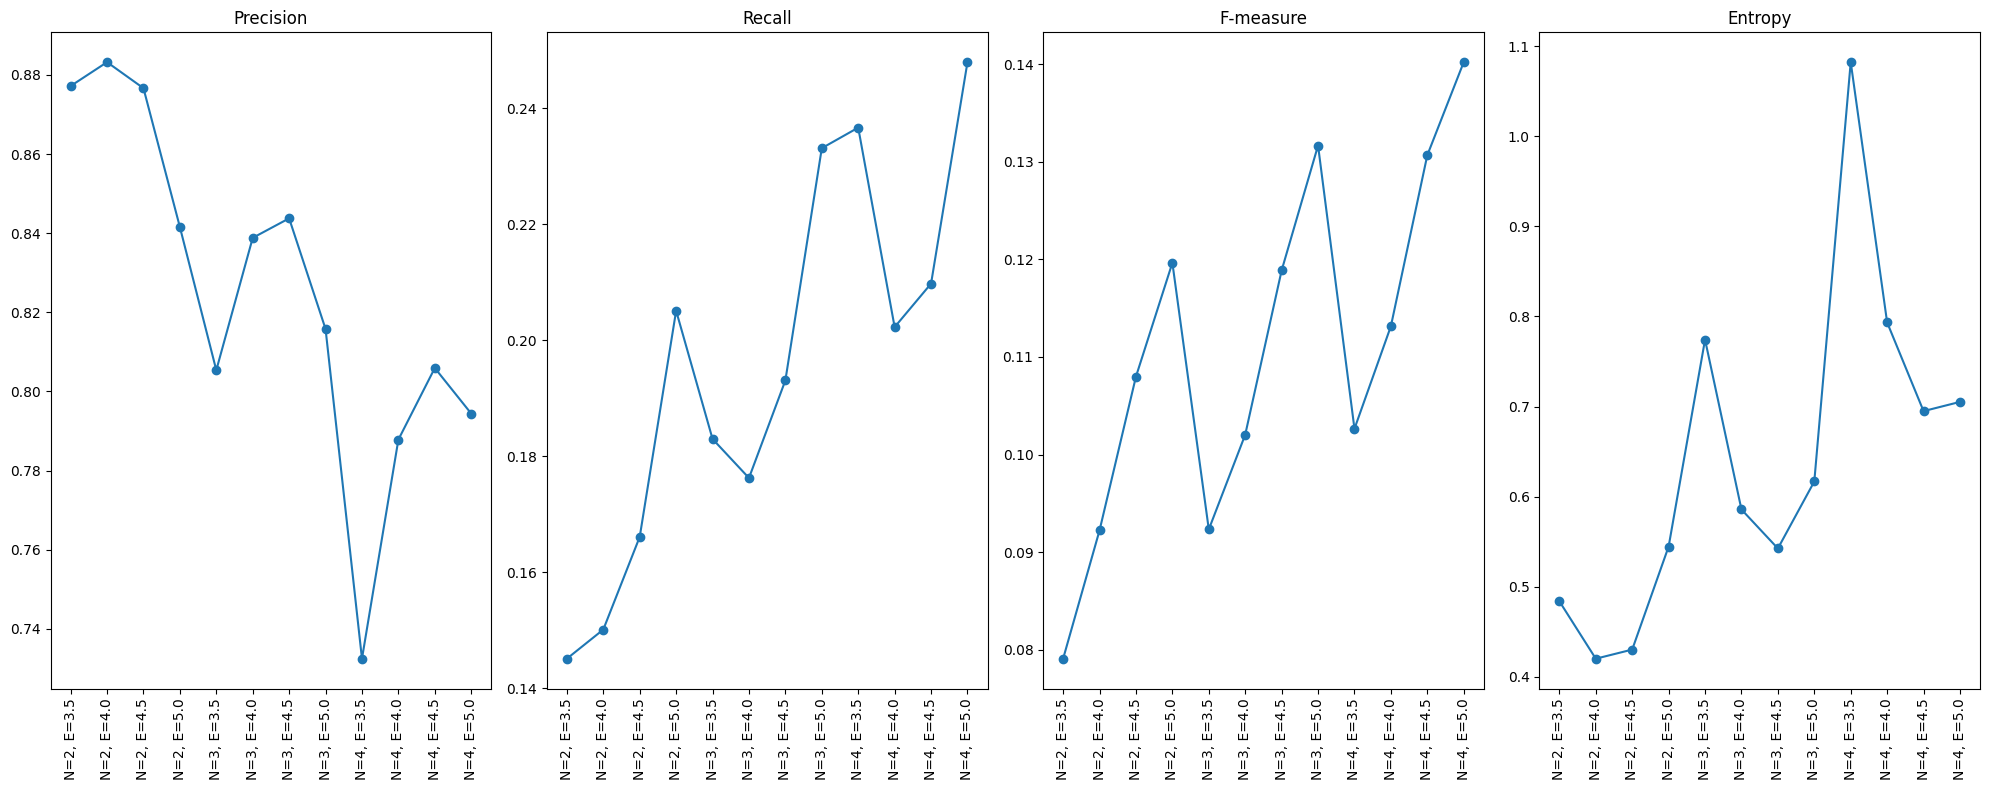

In [308]:
# Create x values for the plot
x_values = [f'N={num}, E={eps}' for num in num_samples_values for eps in eps_values]

# Create the plots
plt.figure(figsize=(20, 8))

plt.subplot(1, 4, 1)
plt.plot(x_values, precision_values, marker='o')
plt.title('Precision')
plt.xticks(rotation=90)

plt.subplot(1, 4, 2)
plt.plot(x_values, recall_values, marker='o')
plt.title('Recall')
plt.xticks(rotation=90)

plt.subplot(1, 4, 3)
plt.plot(x_values, f_measure_values, marker='o')
plt.title('F-measure')
plt.xticks(rotation=90)

plt.subplot(1, 4, 4)
plt.plot(x_values, entropy_values, marker='o')
plt.title('Entropy')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()